# **Importing Modules and Dependencies**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os
import shutil

from PIL import Image
from torch.autograd import Variable

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Data**

# **Data Model**

In [ ]:
root="/content/drive/MyDrive/smart_data_solutions/ML/data"
train_data = datasets.ImageFolder(root=f'{root}/train',
                                  transform=transforms.ToTensor()) #0-255 to 0-1

In [ ]:
test_data = datasets.ImageFolder(root=f'{root}/test',
                                  transform=transforms.ToTensor()) #0-255 to 0-1

In [ ]:
#show img and label
count=0
for img, label in train_data:
  count=count+1
  print(f'{img}   /   {label}')
  if count>3:
    break

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])   /   0
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 

In [ ]:
root_path="/content/drive/MyDrive/smart_data_solutions/ML/data"

print('train')
for folder in train_data.classes:
  print(f'{folder} - {len(os.listdir(os.path.join(f"{root_path}/train",folder)))}')
print('\n')

print('test')
for folder in test_data.classes:
  print(f'{folder} - {len(os.listdir(os.path.join(f"{root_path}/test",folder)))}')
print('\n')

train
0 - 400
2 - 404
4 - 400
6 - 400
9 - 400


test
0 - 100
2 - 102
4 - 100
6 - 100
9 - 100




In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [ ]:
def plot_images(images, labels, classes, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

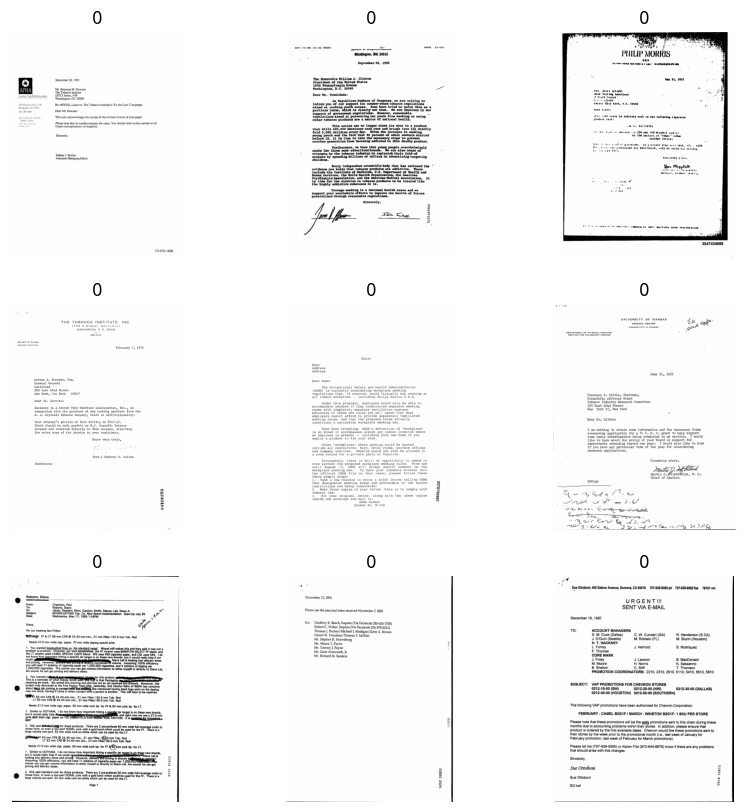

In [ ]:
#for ploting '0' category images

N_IMAGES = 10

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

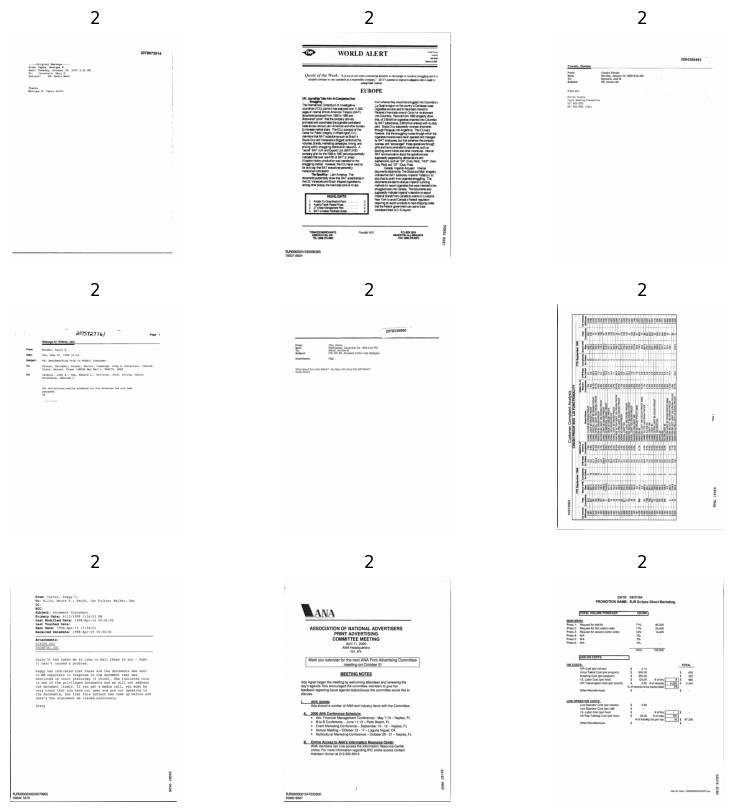

In [ ]:
#for ploting '2' category images

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(400,400+N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transformer = transforms.Compose([
    transforms.Resize([pretrained_size,pretrained_size]),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means,
                         std=pretrained_stds)
])

test_transformer = transforms.Compose([
    transforms.Resize([pretrained_size,pretrained_size]),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means,
                         std=pretrained_stds)
])

In [ ]:
train_data=datasets.ImageFolder(root=f'{root}/train',
                                  transform=train_transformer)

test_data = datasets.ImageFolder(root=f'{root}/test',
                                  transform=test_transformer)

In [ ]:
print(len(train_data))
print(len(test_data))

2004
502


In [ ]:
train_loader=data.DataLoader(train_data,
                             batch_size=32,
                             shuffle=True)

test_loader=data.DataLoader(test_data,
                             batch_size=16,
                             shuffle=True)

In [ ]:
print(len(train_loader))
print(len(test_loader))

63
32


In [ ]:
classes=train_data.classes
print(classes)
num_classes=len(classes)
print(num_classes)

['0', '2', '4', '6', '9']
5


# **Model**

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [ ]:
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

In [ ]:
def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [ ]:
vgg16_layers = get_vgg_layers(vgg16_config, batch_norm=True)

In [ ]:
print(vgg16_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
OUTPUT_DIM = 5

model = VGG(vgg16_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# **Pretrained Model VGG16**

In [ ]:
pretrained_model = models.vgg16_bn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 86.6MB/s]


In [ ]:
print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
pretrained_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
OUTPUT_DIM=5

IN_FEATURES = pretrained_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [ ]:
pretrained_model.classifier[-1] = final_fc

In [ ]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)


In [ ]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 134,289,477 trainable parameters


In [ ]:
# #optimizer and loss function
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
LR = 5e-4

params = [
          {'params': model.features.parameters(), 'lr': LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr=LR)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
from tqdm import tqdm


def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    # count=0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        # count=count+1

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # if count==1:
        #   break

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    # count=0

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            # count=count+1

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            # if count==1:
            #   break

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
num_epochs=5
save_model_path=os.path.join('/content/drive/MyDrive/smart_data_solutions/ML/models/model_vgg16.pt')

best_valid_loss = float('inf')

total_train_loss=[]
total_val_loss=[]

total_train_accuracy=[]
total_val_accuracy=[]

for epoch in trange(num_epochs,desc='Epochs'):
    
    start_time=time.monotonic()

    train_loss,train_accuracy=train(model,train_loader, optimizer,criterion,device)
    total_train_loss.append(train_loss)
    total_train_accuracy.append(train_accuracy)
    
    evaluate_loss,val_accuracy=evaluate(model,test_loader,criterion,device)
    total_val_loss.append(evaluate_loss)
    total_val_accuracy.append(val_accuracy)

    if evaluate_loss<best_valid_loss:
        best_valid_loss=evaluate_loss
        torch.save(model.state_dict(),save_model_path)

    end_time=time.monotonic()

    epoch_mins,epoch_sec=epoch_time(start_time,end_time)

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_sec}s')
    print(f'\tTrain Loss: {train_loss}   |    Train accuracy: {train_accuracy}')
    print(f'\t Val. Loss: {evaluate_loss}   |   Val. accuacy: {val_accuracy}')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]


Training: 100%|██████████| 63/63 [10:32<00:00,  9.03s/it]
                                                         
Evaluating: 100%|██████████| 32/32 [02:30<00:00,  3.99s/it]
                                                           

Epoch: 01 | Time: 13m 5s
	Train Loss: 0.7410135789523049   |    Train accuracy: 0.7401785718070136
	 Val. Loss: 0.3874748153029941   |   Val. accuacy: 0.873046875



Training: 100%|██████████| 63/63 [01:01<00:00,  1.22it/s]
                                                         
Evaluating: 100%|██████████| 32/32 [00:09<00:00,  3.25it/s]
                                                           

Epoch: 02 | Time: 1m 10s
	Train Loss: 0.355686975022157   |    Train accuracy: 0.889980159108601
	 Val. Loss: 0.5035763728665188   |   Val. accuacy: 0.858723958954215



Training: 100%|██████████| 63/63 [00:59<00:00,  1.21it/s]
                                                         
Evaluating: 100%|██████████| 32/32 [00:09<00:00,  4.46it/s]
                                                           

Epoch: 03 | Time: 1m 8s
	Train Loss: 0.28691166343670044   |    Train accuracy: 0.9084325394933186
	 Val. Loss: 0.5022735223174095   |   Val. accuacy: 0.8561197929084301



Training: 100%|██████████| 63/63 [00:57<00:00,  1.21it/s]
                                                         
Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]
                                                           

Epoch: 04 | Time: 1m 6s
	Train Loss: 0.2101516289015611   |    Train accuracy: 0.9351190479974898
	 Val. Loss: 0.42100463493261486   |   Val. accuacy: 0.896484375



Training: 100%|██████████| 63/63 [00:57<00:00,  1.20it/s]
                                                         
Evaluating: 100%|██████████| 32/32 [00:08<00:00,  4.01it/s]
                                                           

Epoch: 05 | Time: 1m 5s
	Train Loss: 0.17216323800237168   |    Train accuracy: 0.9458333339009967
	 Val. Loss: 0.4967755760926593   |   Val. accuacy: 0.88671875


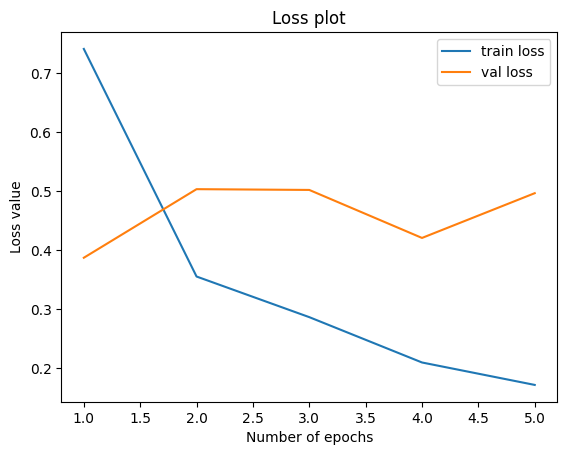

In [ ]:
epochs=[a for a in range(1,num_epochs+1)]
plt.plot(epochs,total_train_loss,label='train loss')
plt.plot(epochs,total_val_loss,label='val loss')
plt.title('Loss plot')
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')

plt.legend()
plt.show()

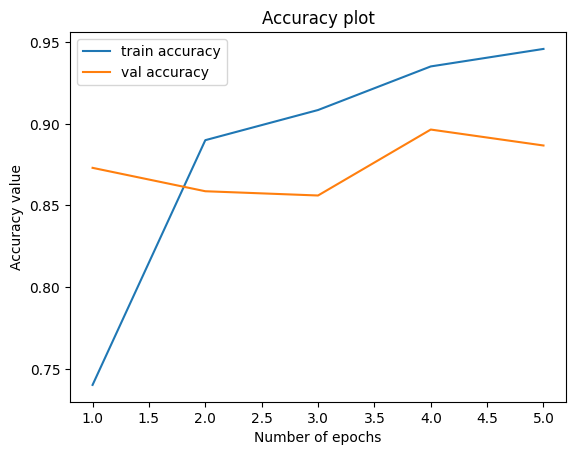

In [ ]:
epochs=[a for a in range(1,num_epochs+1)]
plt.plot(epochs,total_train_accuracy,label='train accuracy')
plt.plot(epochs,total_val_accuracy,label='val accuracy')
plt.title('Accuracy plot')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy value')

plt.legend()
plt.show()

# **Evaluation Metrics**

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_loader)

100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Greens', ax=ax)
    plt.xticks(rotation=20)

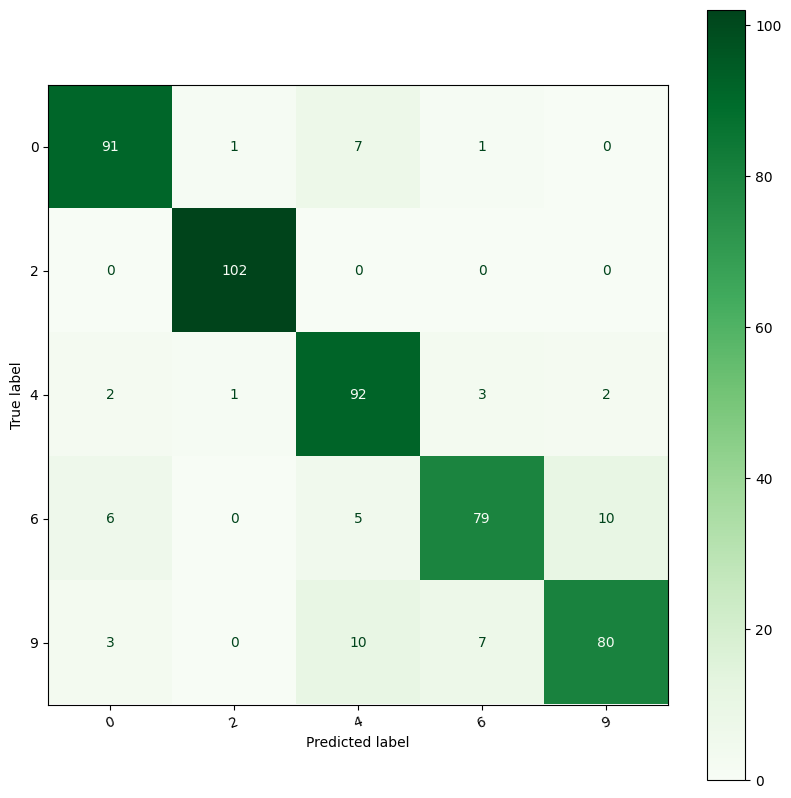

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
from sklearn.metrics import accuracy_score
# accuracy
accuracy_score(labels,pred_labels)

0.8844621513944223

In [ ]:
from sklearn.metrics import f1_score
#f1 score
f1_score(labels,pred_labels,average='weighted')

0.883627998247499

In [ ]:
from sklearn.metrics import f1_score
#f1 score
f1_score(labels,pred_labels,average='macro')

0.8832013451919455

In [ ]:
from sklearn.metrics import f1_score
#f1 score
f1_score(labels,pred_labels,average='micro')

0.8844621513944223

In [ ]:
#precision
from sklearn.metrics import precision_score
precision_score(labels, pred_labels,average='weighted')

0.8858370552108454

In [ ]:
#recall
from sklearn.metrics import recall_score
recall_score(labels, pred_labels,average='weighted')

0.8844621513944223

# **Inference**

In [ ]:
model_path=os.path.join('/content/drive/MyDrive/smart_data_solutions/ML/models/model_vgg16.pt')
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
classes = ['0', '2', '4', '6', '9']

In [ ]:
def prediction(img_path,transformer):
  image=Image.open(img_path)

  # Convert grayscale image to RGB
  image = image.convert("RGB")
    
  image_tensor=transformer(image).float()
  # print(image_tensor)
  
  
  image_tensor=image_tensor.unsqueeze_(0)
  # print(image_tensor)

  image_tensor=image_tensor.to(device)
  
  # if torch.cuda.is_available():
  #     image_tensor.cuda()
      
  input=Variable(image_tensor)
  
  
  y_pred,_=model(input)

  # y_prob = F.softmax(y_pred, dim=-1)
  
  index=y_pred.cpu().data.numpy().argmax()
  
  pred=classes[index]
  
  return pred

In [ ]:
imp='/content/drive/MyDrive/smart_data_solutions/ML/data/0_category.TIF'

predic=prediction(imp,test_transformer)

print(predic)

4
